In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf
from scipy.stats import norm
import matplotlib.pyplot as plt
import statsmodels.stats.diagnostic as diag
from pmdarima import auto_arima
import statsmodels.formula.api as smf
from sklearn.model_selection import TimeSeriesSplit
from collections import namedtuple
import statsmodels.api as sm


# Exploratory analysis of SPREAD
Exploring the data monthly interval data, there appears to be heteroskedasticity present in the SPREAD time series as well as the differenced time series. For purposes of this project, data from 1985-07-01 onwards will be used, so as to meet the homoskedasticity assumption of ARIMA models. Future work could consider more advanced model fitting that accomodates this heteroskedasticity in the full time series.

In [2]:
treasury_month = pd.read_csv("DGS30 Monthly.csv")
mortgage_month = pd.read_csv("MORTGAGE30US Monthly.csv")
data_month = pd.merge(treasury_month, mortgage_month, on = "DATE")
data_month["SPREAD"] = data_month.MORTGAGE30US - data_month.DGS30
data_month.index = pd.to_datetime(data_month.DATE)
data_month['SHIFT'] = data_month.SPREAD.shift(1)
data_month["DIFF"] = data_month.SPREAD - data_month.SHIFT
data_month["DIFF_SHIFT"] = data_month.DIFF.shift(1)
data_month["DIFF2"] = data_month.DIFF - data_month.DIFF_SHIFT
print(data_month.head())
print(data_month.tail())

                  DATE     DGS30  MORTGAGE30US    SPREAD     SHIFT      DIFF  \
DATE                                                                           
1977-03-01  1977-03-01  7.796087        8.6875  0.891413       NaN       NaN   
1977-04-01  1977-04-01  7.734500        8.7520  1.017500  0.891413  0.126087   
1977-05-01  1977-05-01  7.798095        8.8275  1.029405  1.017500  0.011905   
1977-06-01  1977-06-01  7.635909        8.8575  1.221591  1.029405  0.192186   
1977-07-01  1977-07-01  7.644737        8.9420  1.297263  1.221591  0.075672   

            DIFF_SHIFT     DIFF2  
DATE                              
1977-03-01         NaN       NaN  
1977-04-01         NaN       NaN  
1977-05-01    0.126087 -0.114182  
1977-06-01    0.011905  0.180281  
1977-07-01    0.192186 -0.116514  
                  DATE     DGS30  MORTGAGE30US    SPREAD     SHIFT      DIFF  \
DATE                                                                           
2023-11-01  2023-11-01  4.660000  

In [3]:
print(data_month.loc[data_month.SPREAD <= 0,])

Empty DataFrame
Columns: [DATE, DGS30, MORTGAGE30US, SPREAD, SHIFT, DIFF, DIFF_SHIFT, DIFF2]
Index: []


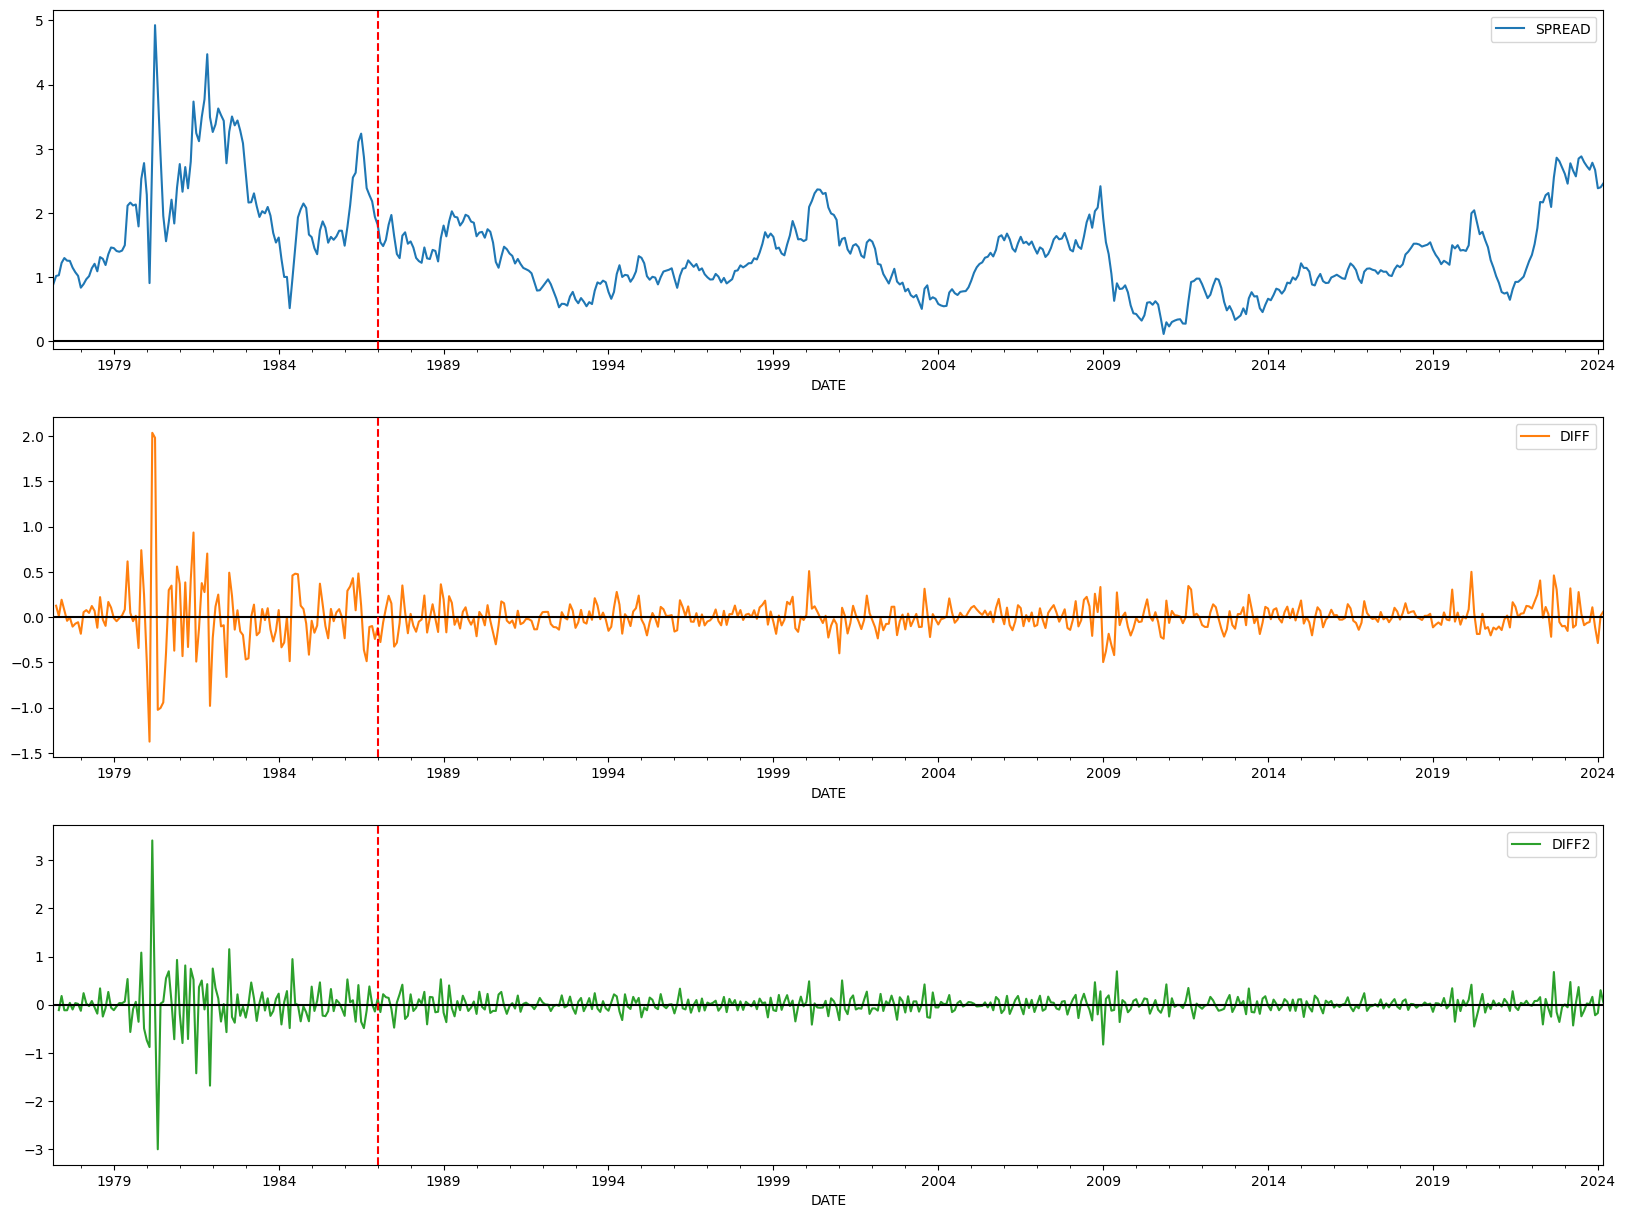

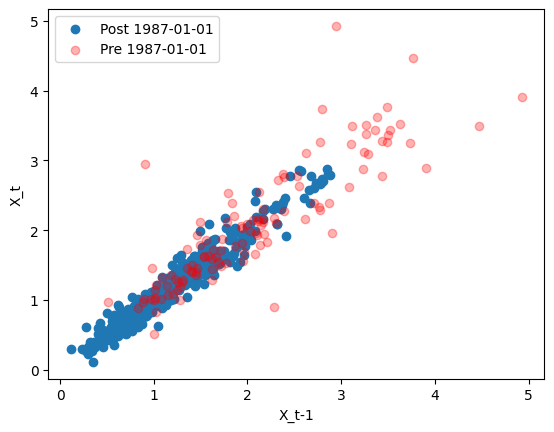

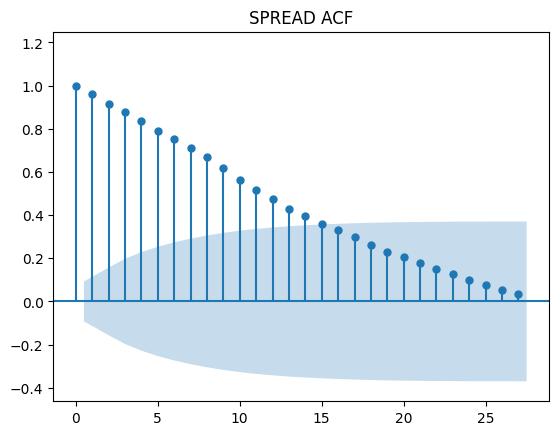

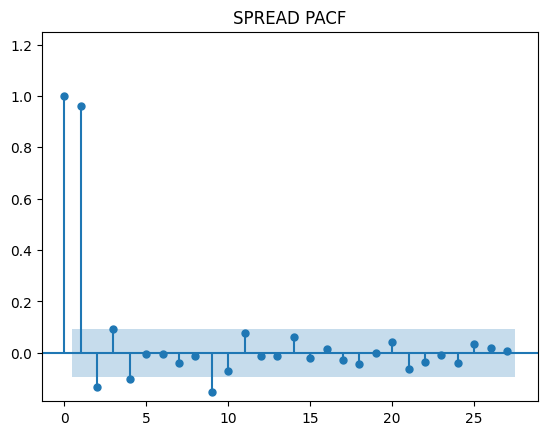

In [4]:
data_start_date = pd.to_datetime('1987-01-01')#data from before this point discarded for heteroskedasticity

axes = data_month[['SPREAD', 'DIFF','DIFF2']].plot(figsize=(20,15), subplots=True, sharex=False)
for ax in axes:
    ax.axhline(y=0, color="black")
    ax.axvline(data_start_date,linestyle="--", color='red')
plt.show()


mark1=plt.scatter(data_month.SHIFT[data_start_date:],data_month.SPREAD[data_start_date:])
mark2=plt.scatter(data_month.SHIFT[:data_start_date], data_month.SPREAD[:data_start_date], color = 'red', alpha = .3)
plt.legend([mark1,mark2], ['Post 1987-01-01', 'Pre 1987-01-01'])
plt.xlabel("X_t-1")
plt.ylabel("X_t")
plt.show()

plot_acf(data_month.SPREAD[data_start_date:], zero=True, auto_ylims=True)
plt.title("SPREAD ACF")
plt.show()
plot_pacf(data_month.SPREAD[data_start_date:], zero=True, auto_ylims=True)
plt.title("SPREAD PACF")
plt.show()



# Model Fitting
## AR(1)
Comparing the residuals of the AR(1) model fit with the full time series to the residuals of AR(1) model fith with data from 1985-07-01 onwards, it is apparent that their skew and kurtosis improve substaintially.

In [5]:
def ARIMA_fit(data, AR=1, I=0, MA=0):
    model = ARIMA(data, order = (AR,I,MA))
    model_fit = model.fit()
    resid = model_fit.resid
    resid_acf = acf(resid)
    print(model_fit.summary())
    N= len(resid)
    print('95% CI: +/-' + str(1.96/(N**.5)))
    model_fit.plot_diagnostics(figsize=(15, 12))
    plt.show()
    plot_acf(resid, zero=False, auto_ylims=True)
    plt.show()
    result = namedtuple("result", ['model_fit','data','p', 'd','q'])
    return result(model_fit, data, AR, I, MA)

C:\Users\bmari\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\bmari\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\bmari\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 SPREAD   No. Observations:                  565
Model:                 ARIMA(1, 0, 0)   Log Likelihood                  24.391
Date:                Sun, 05 May 2024   AIC                            -42.782
Time:                        02:04:31   BIC                            -29.772
Sample:                    03-01-1977   HQIC                           -37.704
                         - 03-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4323      0.240      5.975      0.000       0.962       1.902
ar.L1          0.9460      0.009    102.026      0.000       0.928       0.964
sigma2         0.0535      0.001     53.613      0.0

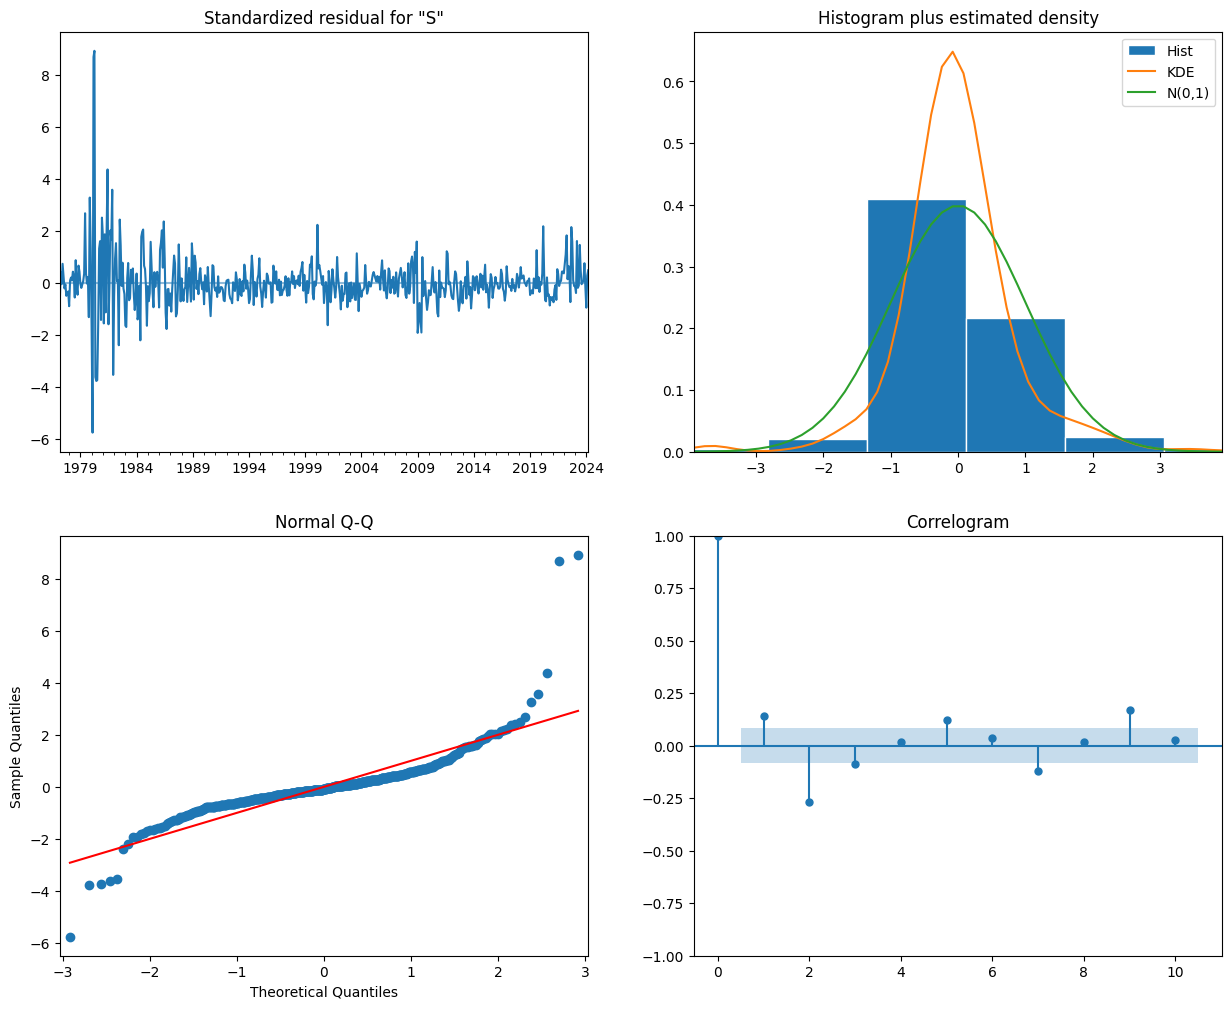

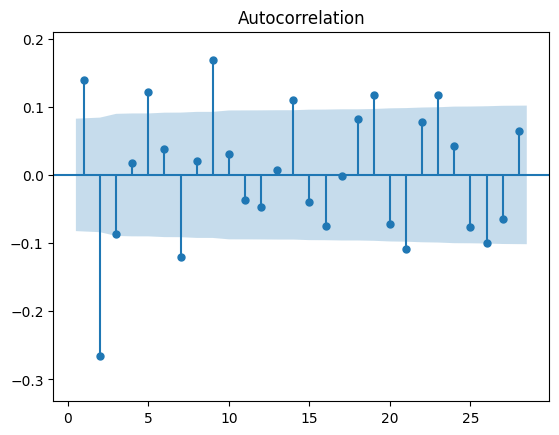

C:\Users\bmari\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\bmari\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\bmari\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 SPREAD   No. Observations:                  447
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 272.905
Date:                Sun, 05 May 2024   AIC                           -539.810
Time:                        02:04:32   BIC                           -527.503
Sample:                    01-01-1987   HQIC                          -534.958
                         - 03-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3683      0.229      5.980      0.000       0.920       1.817
ar.L1          0.9737      0.011     91.641      0.000       0.953       0.995
sigma2         0.0172      0.001     20.135      0.0

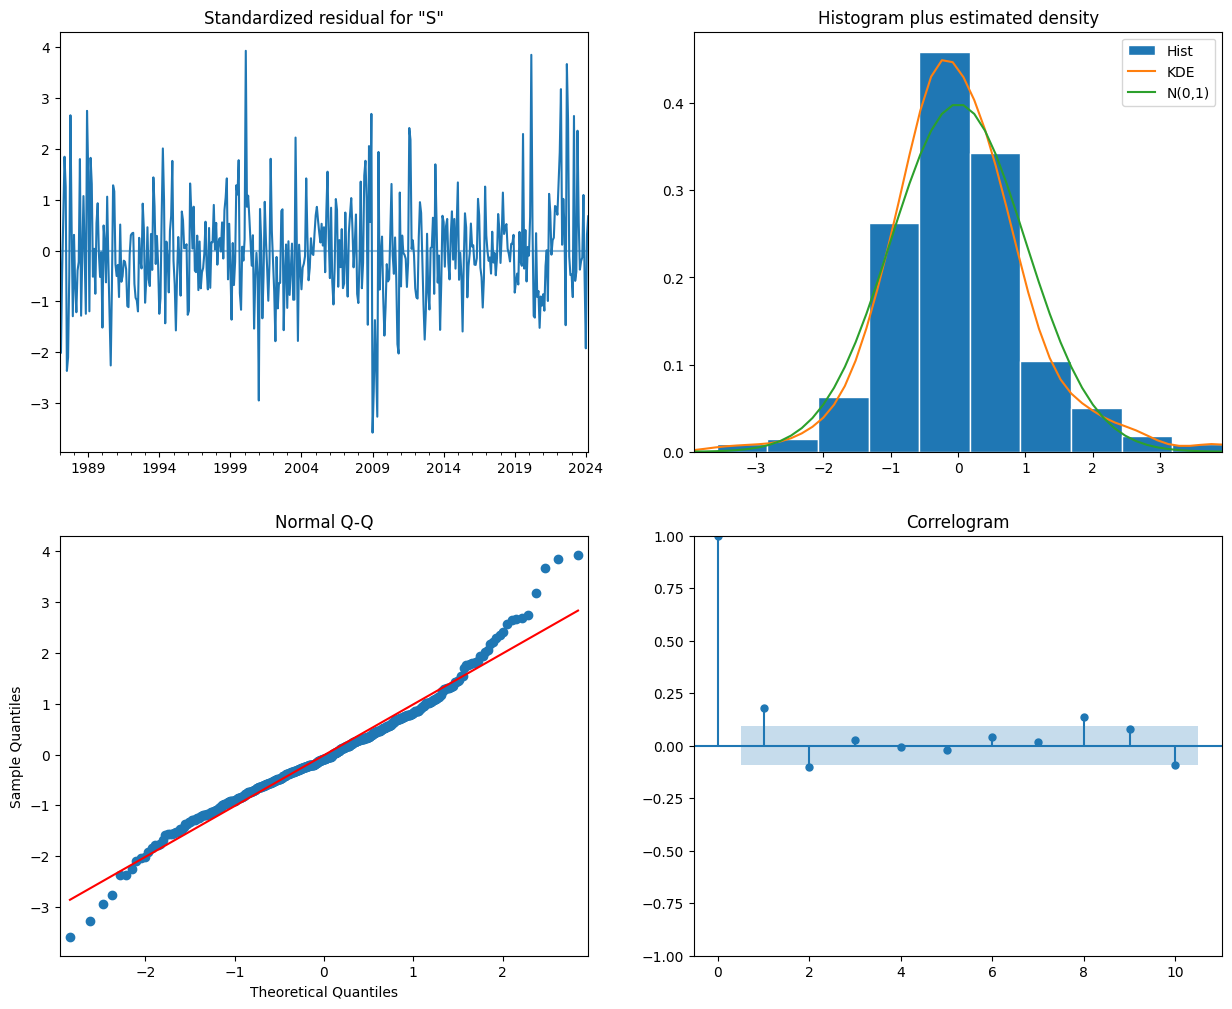

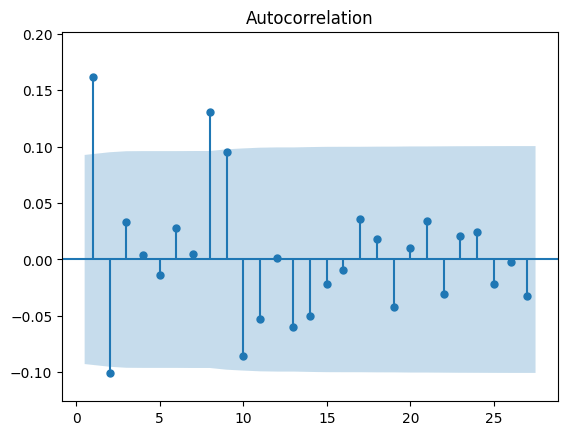

In [6]:
ARIMA_fit(data_month.SPREAD)
model_100=ARIMA_fit(data_month.loc[data_start_date:,'SPREAD'])

## ARIMA(1,1,0)

C:\Users\bmari\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\bmari\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\bmari\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 SPREAD   No. Observations:                  565
Model:                 ARIMA(1, 1, 0)   Log Likelihood                  21.778
Date:                Sun, 05 May 2024   AIC                            -39.555
Time:                        02:04:56   BIC                            -30.885
Sample:                    03-01-1977   HQIC                           -36.171
                         - 03-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1178      0.010     12.100      0.000       0.099       0.137
sigma2         0.0542      0.001     58.931      0.000       0.052       0.056
Ljung-Box (L1) (Q):                   0.80   Jarque-

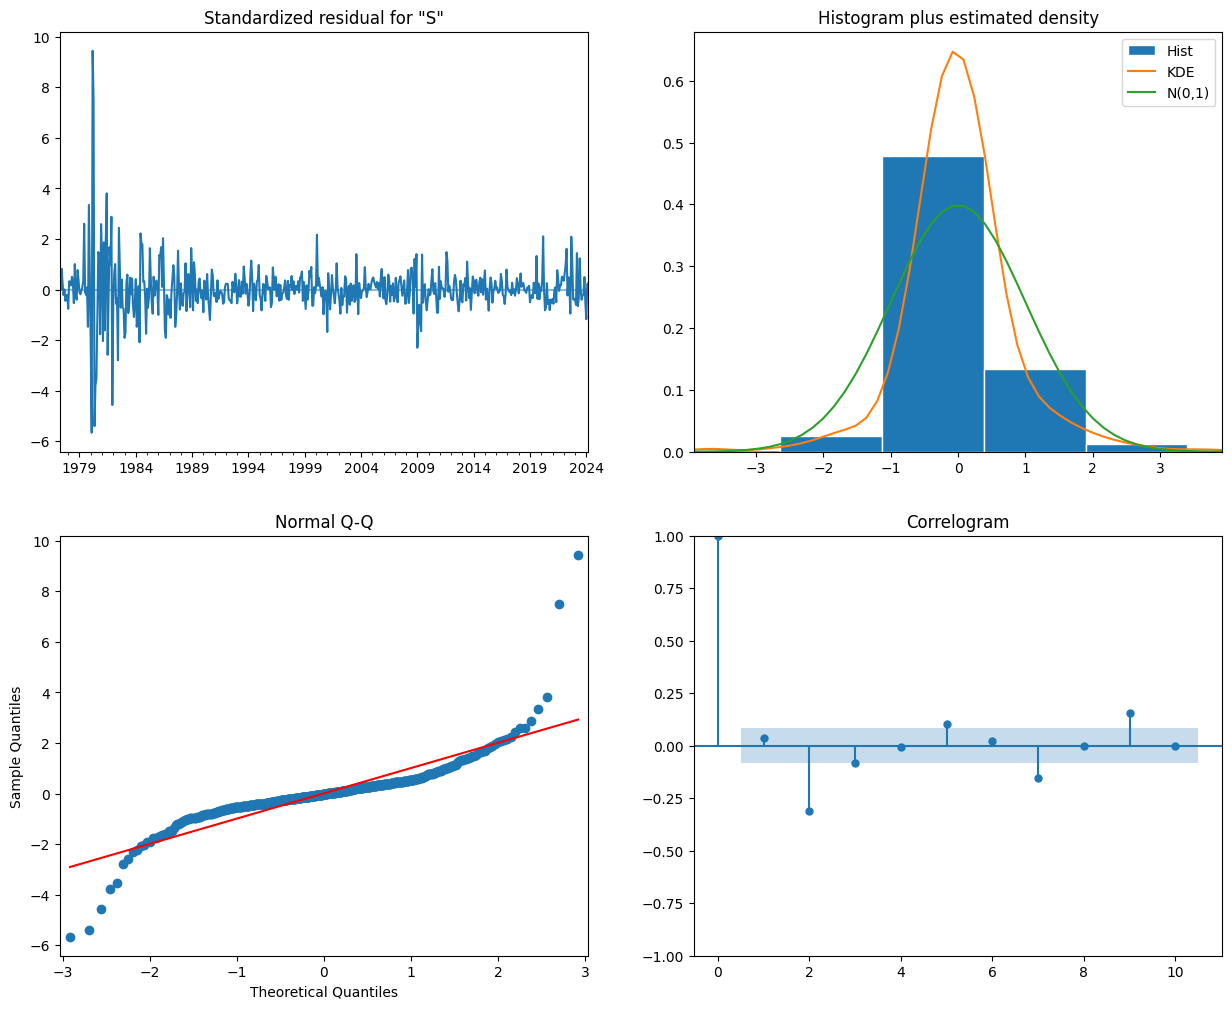

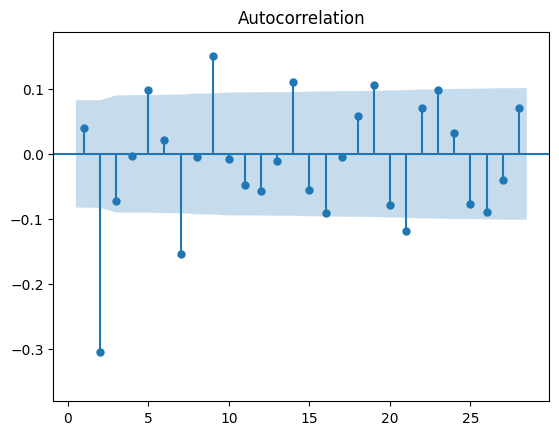

C:\Users\bmari\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\bmari\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\bmari\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 SPREAD   No. Observations:                  447
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 277.598
Date:                Sun, 05 May 2024   AIC                           -551.197
Time:                        02:04:57   BIC                           -542.996
Sample:                    01-01-1987   HQIC                          -547.963
                         - 03-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1702      0.036      4.666      0.000       0.099       0.242
sigma2         0.0169      0.001     20.777      0.000       0.015       0.018
Ljung-Box (L1) (Q):                   0.26   Jarque-

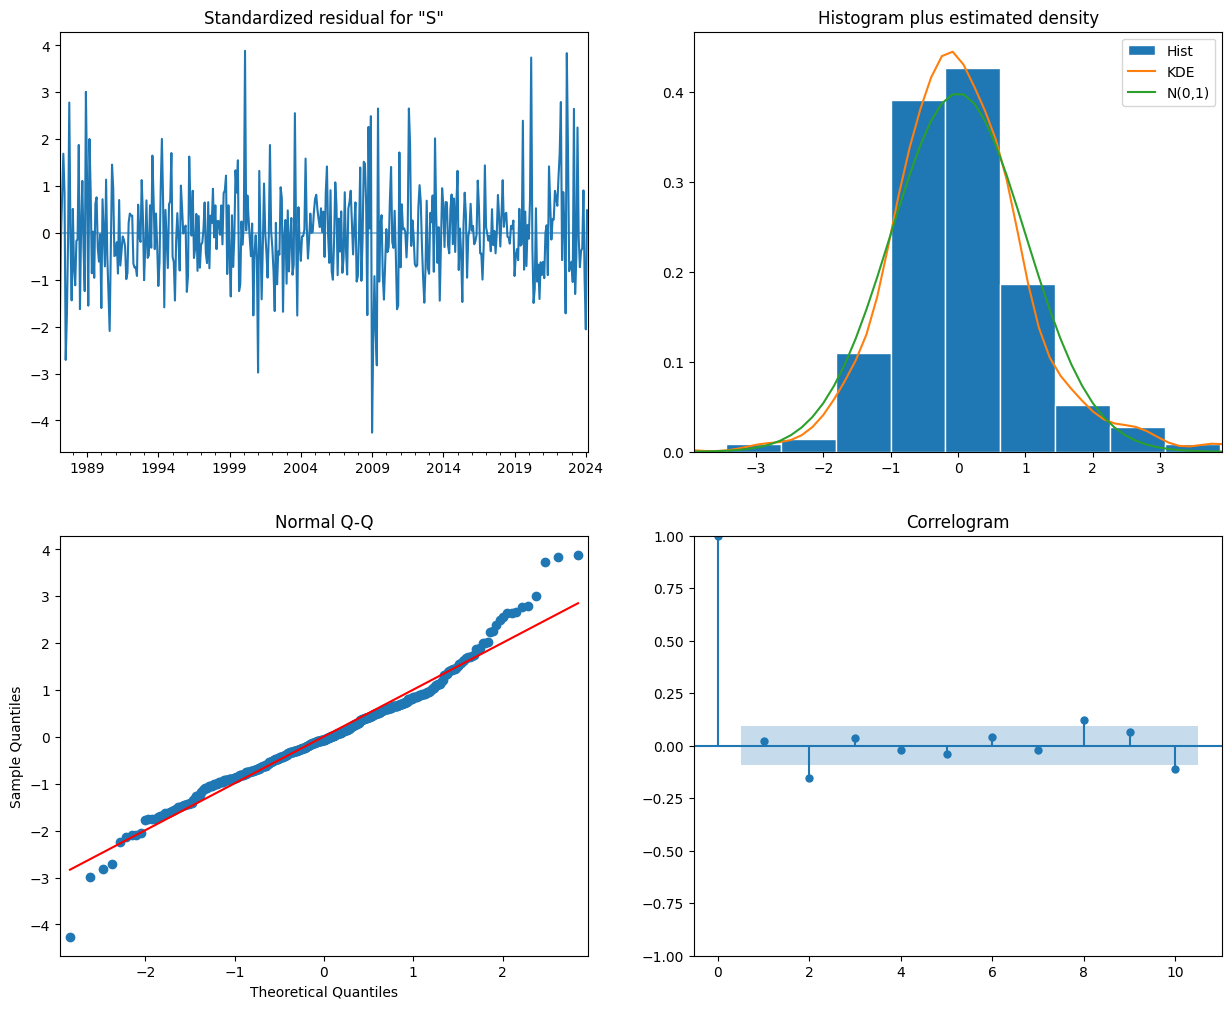

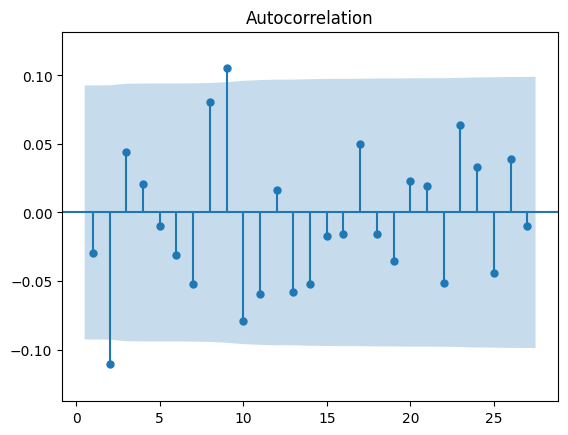

In [8]:
ARIMA_fit(data_month.SPREAD, 1,1,0)
model_110 = ARIMA_fit(data_month.loc[data_start_date:,'SPREAD'], 1, 1, 0)

## AUTO ARIMA SPREAD

In [9]:
model_auto = auto_arima(data_month.loc[data_start_date:,'SPREAD'],
                        start_p=1,
                        start_q=1,
                        D=0)

C:\Users\bmari\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\bmari\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\bmari\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 SPREAD   No. Observations:                  447
Model:                 ARIMA(1, 0, 2)   Log Likelihood                 286.111
Date:                Sun, 05 May 2024   AIC                           -562.222
Time:                        02:05:11   BIC                           -541.709
Sample:                    01-01-1987   HQIC                          -554.135
                         - 03-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3499      0.211      6.386      0.000       0.936       1.764
ar.L1          0.9683      0.012     77.925      0.000       0.944       0.993
ma.L1          0.2263      0.039      5.789      0.0

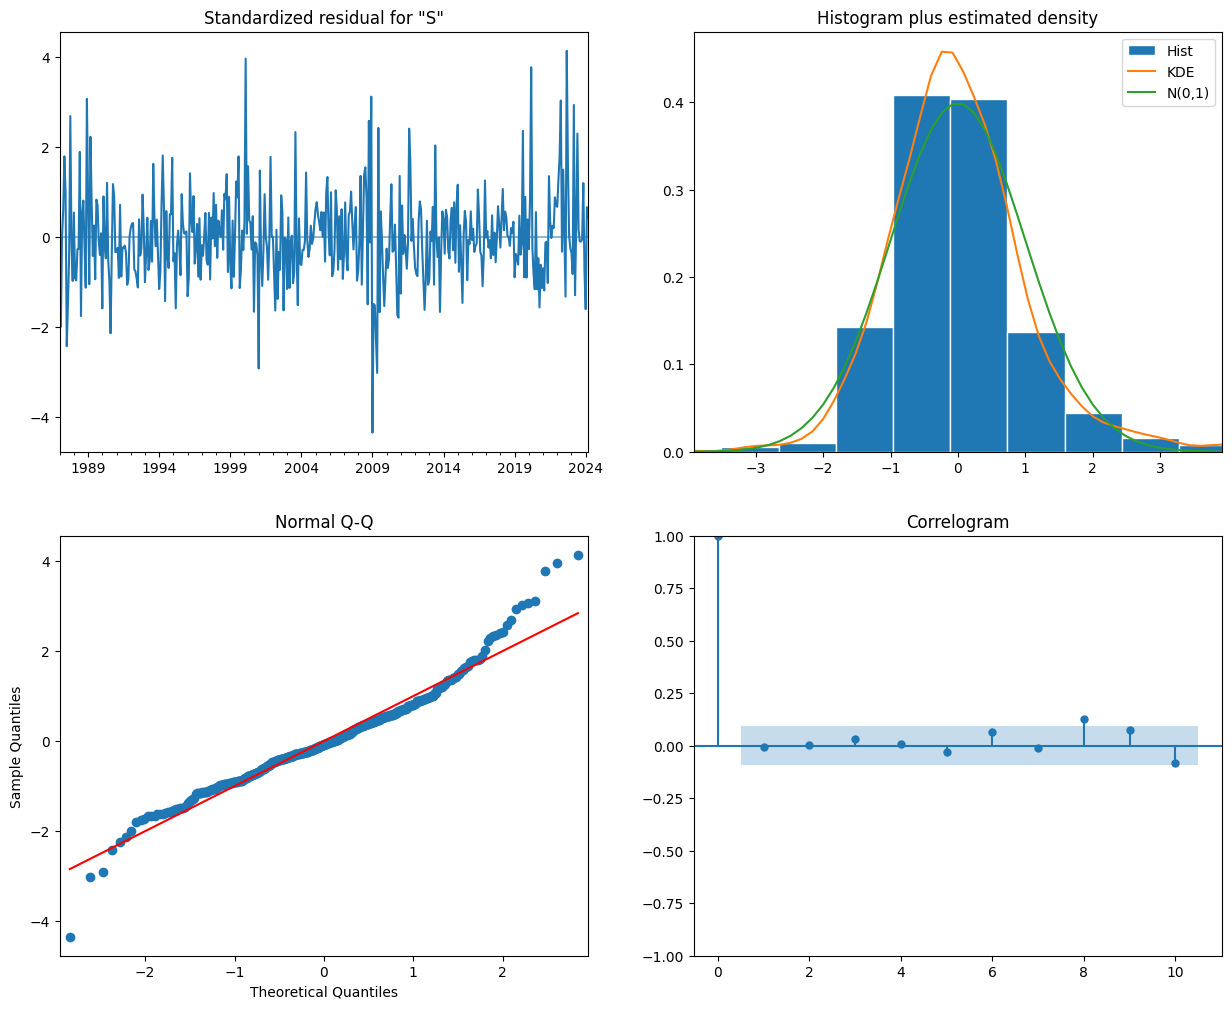

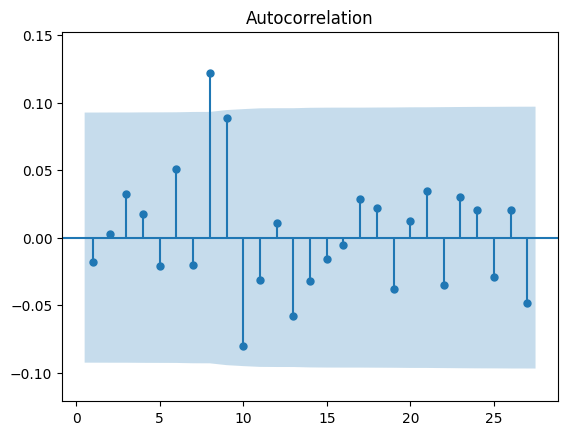

In [10]:
model_auto = ARIMA_fit(data_month.loc[data_start_date:,'SPREAD'], model_auto.order[0], model_auto.order[1], model_auto.order[2])

# Cross Validation

In [11]:
#function for crossvalidation
def cross_validation(model_fit, len_out = 20, pred_start = None ):
    if pred_start is None:
        pred_start = len_out
    data = model_fit.data
    p = model_fit.p
    d = model_fit.d
    q = model_fit.q
    #add code to check if data_stop + len_out > len(model_fit.fittedvalues -1)
    
    e = np.zeros(len(data) - len_out - pred_start) #creating numpy array to house error for each validation
    actual = np.zeros(len(data) - len_out - pred_start) #creating numpy array to house actual validation data
    for i in range(pred_start, len(data) - len_out):

        #need to add in means to get origial training data then partition into new training and validation data
        train = data[0:i]
        y = data[i + len_out]
        cv_model= ARIMA(train, order = (p,d,q))
        cv_model_fit = cv_model.fit()
        y_hat = cv_model_fit.forecast(len_out)[-1] #predicting values based on test data
        e[i-pred_start] = y - y_hat
        actual[i-pred_start] = y
    MSE = (e**2).mean()
    RMSE = np.sqrt(MSE)
    MAE = np.abs(e).mean()
    MAPE = np.abs(e/actual).mean()
    result = namedtuple("result", ['e','RMSE', 'MAE','MAPE'])
    return result(e, RMSE, MAE, MAPE)

In [12]:
import warnings
warnings.filterwarnings('ignore')

len_out = 12*15
pred_start = len_out

model_100_result = cross_validation(model_100, len_out =len_out, pred_start = pred_start)
model_110_result = cross_validation(model_110, len_out =len_out, pred_start = pred_start)
model_auto_result = cross_validation(model_auto, len_out =len_out, pred_start = pred_start)



      ARIMA(1,0,0)  ARIMA(1,1,0)  ARIMA(1,0,2)
RMSE      0.709616      0.709777      0.707615
MAE       0.529328      0.628703      0.528642
MAPE      0.295008      0.408086      0.295184


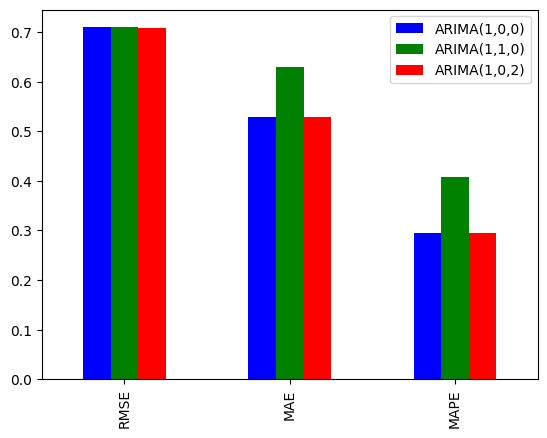

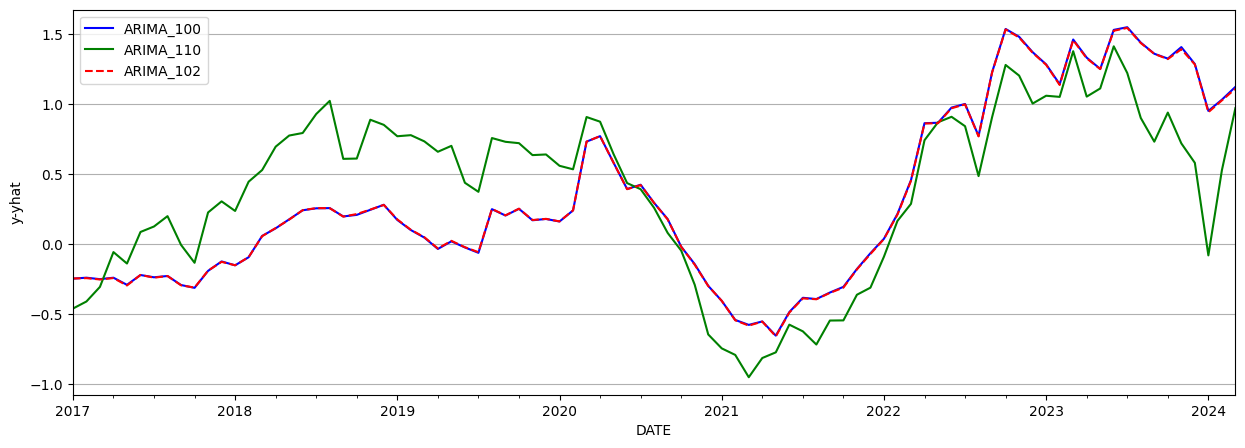

In [13]:
cross_val_metrics = pd.DataFrame((model_100_result[1:4], model_110_result[1:4], model_auto_result[1:4]), columns = ["RMSE", "MAE", "MAPE"], index = ["ARIMA(1,0,0)", "ARIMA(1,1,0)", "ARIMA(1,0,2)"]).transpose()
cross_val_errors  = pd.DataFrame((model_100_result.e, model_110_result.e, model_auto_result.e), index = ["ARIMA_100", "ARIMA_110", "ARIMA_102"] ).transpose()
cross_val_errors.index = data_month[data_start_date:].index[pred_start + len_out:]
print(cross_val_metrics)
cross_val_metrics.plot.bar(color = ['blue', 'green', 'red'])
plt.show()
cross_val_errors.plot(style=["-","-","--"], color = ['blue', 'green', 'red'], figsize=(15,5))
plt.grid(visible=True, axis='y')
plt.ylabel("y-yhat")
plt.show()


# Forecasting and Simulation

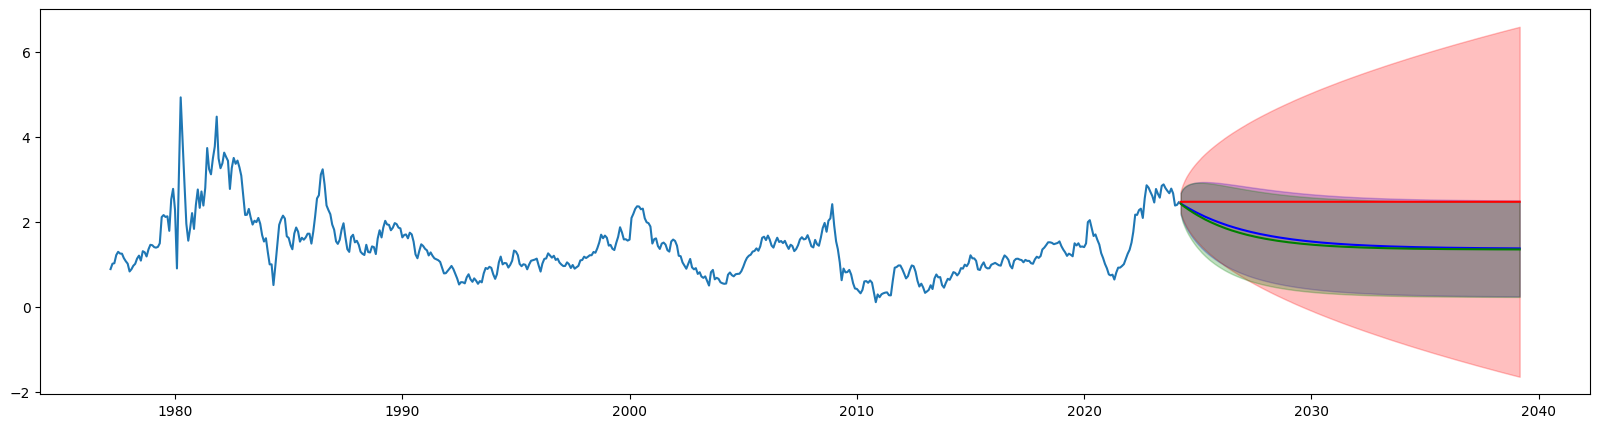

2024-04-01    2.470385
2024-05-01    2.472153
2024-06-01    2.472454
2024-07-01    2.472505
2024-08-01    2.472514
                ...   
2038-11-01    2.472515
2038-12-01    2.472515
2039-01-01    2.472515
2039-02-01    2.472515
2039-03-01    2.472515
Freq: MS, Name: predicted_mean, Length: 180, dtype: float64


In [14]:
plt.figure(figsize = (20,5))
plt.plot(data_month.index, data_month.SPREAD)

forecast_100 = model_100.model_fit.get_forecast(12*15)
forecast_110 = model_110.model_fit.get_forecast(12*15)
forecast_auto = model_auto.model_fit.get_forecast(12*15)

for color,forecast in {'blue':forecast_100, 'red':forecast_110, 'green':forecast_auto}.items():

    plt.plot(forecast.predicted_mean, color=color)
    plt.fill_between(forecast.conf_int().index,
                    forecast.conf_int()['lower SPREAD'],
                    forecast.conf_int()['upper SPREAD'],
                    alpha = .25, color = color)
plt.show()
print(forecast_110.predicted_mean)

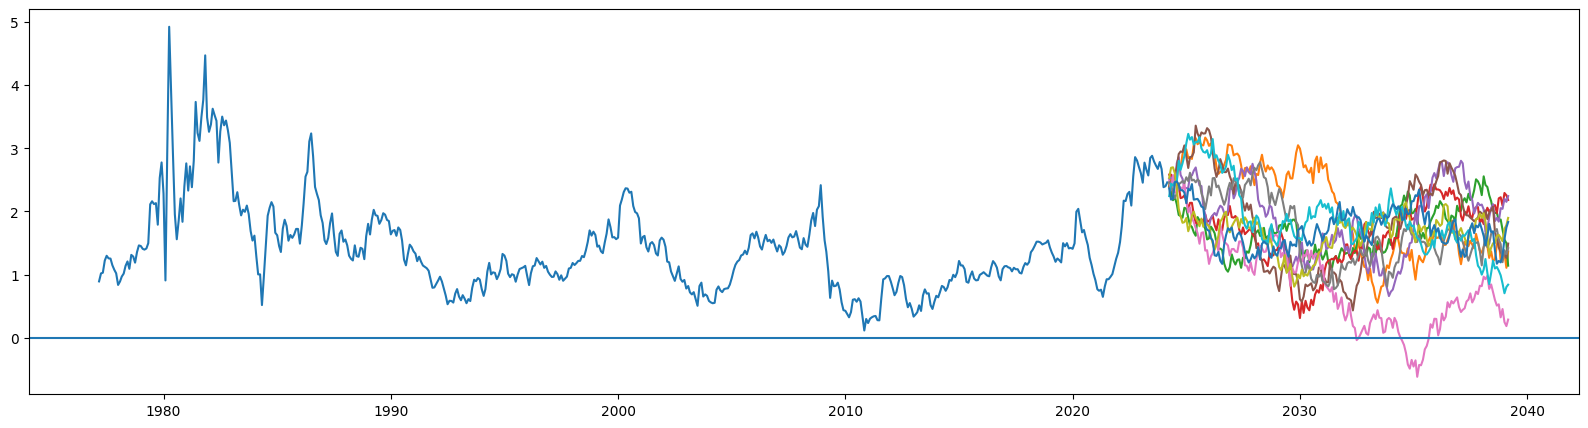

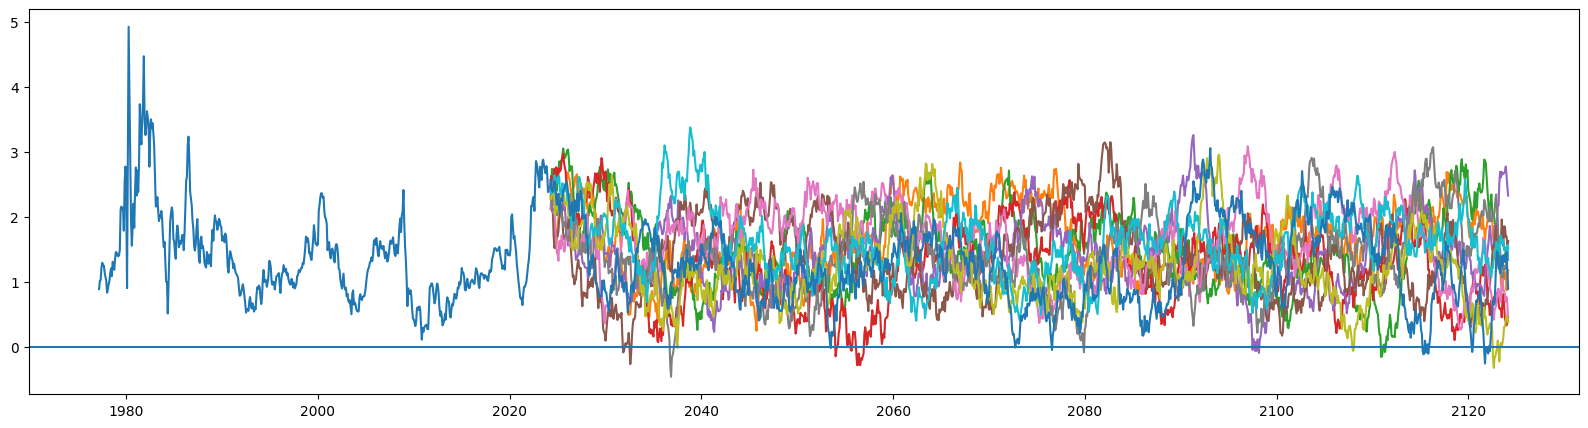

In [15]:
plt.figure(figsize = (20,5))
plt.plot(data_month.index, data_month.SPREAD)

sim = model_100.model_fit.simulate(anchor='end', nsimulations = 12*15, repetitions=10)
plt.plot(sim.index, sim)
plt.axhline(y=0)
plt.show()
plt.figure(figsize = (20,5))
plt.plot(data_month.index, data_month.SPREAD)

sim = model_100.model_fit.simulate(anchor='end', nsimulations = 12*100, repetitions=10)
plt.plot(sim.index, sim)
plt.axhline(y=0)
plt.show()

In [16]:
num_sim = [5, 10,100,1000,10000,100000]
empirical_mean = np.zeros(len(num_sim))
for i,j in enumerate(num_sim):
    sim = model_100.model_fit.simulate(anchor='end', nsimulations = 12*100, repetitions=j)
    empirical_mean[i] = sim.iloc[-1,:].mean()


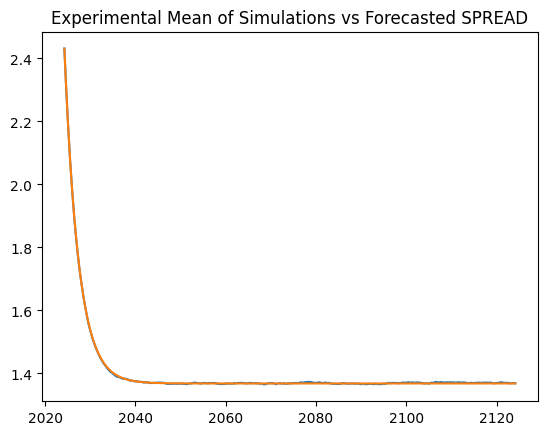

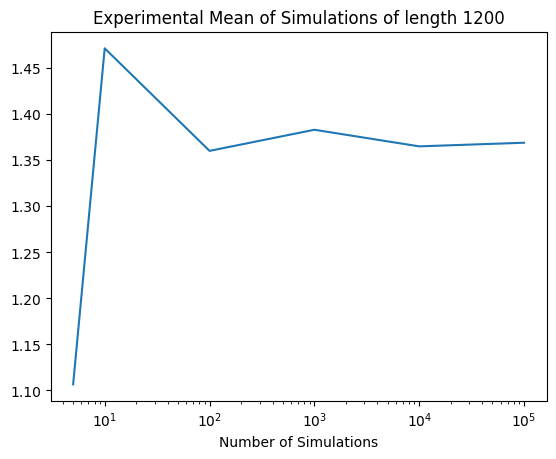

[1.10663564 1.47128086 1.35998608 1.38290021 1.36488827 1.36882408]


In [17]:
sim["MEAN"] = sim.apply(func='mean', axis=1)
plt.plot(sim.MEAN)
plt.title("Experimental Mean of Simulations vs Forecasted SPREAD")
plt.plot(model_100.model_fit.forecast(12*100))
plt.show()

plt.plot(num_sim,empirical_mean)
plt.title("Experimental Mean of Simulations of length 1200")
plt.xscale('log')
plt.xlabel("Number of Simulations")
plt.plot()
plt.show()
print(empirical_mean)

In [18]:
c=model_100.model_fit.params['const']
a=model_100.model_fit.params['ar.L1']
print(c)
print(a)
print(c/(1-a))

#augmeted dickey fuller test on data, H0:nonstationary, H1:stationary
a = sm.tsa.stattools.adfuller(data_month.SPREAD[data_start_date:], maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)
print(a)
if a[1] < .05:
    print('stationary')
else:
    print('non-stationary')


#KPSS stationary test, H0: stationary, H1: non-stationary
b = sm.tsa.stattools.kpss(data_month.SPREAD[data_start_date:,], regression="c", nlags="auto")
print(b)
if b[1] > .05:
    print('stationary')
else:
    print('non-stationary')

1.3682584992859739
0.9736918251064774
52.00887195040119
(-3.0448438517363905, 0.030913510997104453, 8, 438, {'1%': -3.445368352170937, '5%': -2.8681614049724002, '10%': -2.570296970872167}, -566.8529762620719)
stationary
(0.22662670219760736, 0.1, 12, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
stationary


# Latex Table Generation

In [19]:
#AR(1) summary table
print(model_100.model_fit.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}          &      SPREAD      & \textbf{  No. Observations:  } &    447      \\
\textbf{Model:}                  &  ARIMA(1, 0, 0)  & \textbf{  Log Likelihood     } &  272.905    \\
\textbf{Date:}                   & Sun, 05 May 2024 & \textbf{  AIC                } &  -539.810   \\
\textbf{Time:}                   &     02:09:00     & \textbf{  BIC                } &  -527.503   \\
\textbf{Sample:}                 &    01-01-1987    & \textbf{  HQIC               } &  -534.958   \\
\textbf{}                        &   - 03-01-2024   & \textbf{                     } &             \\
\textbf{Covariance Type:}        &       opg        & \textbf{                     } &             \\
\bottomrule
\end{tabular}
\begin{tabular}{lcccccc}
                & \textbf{coef} & \textbf{std err} & \textbf{z} & \textbf{P$> |$z$|$} & \textbf{[0.025} & \textbf{0.975]}  \\
\midrule
\textbf{const}  &       1.3683  &        0.229     &  

                               SARIMAX Results                                
Dep. Variable:                 SPREAD   No. Observations:                  565
Model:                 ARIMA(1, 0, 0)   Log Likelihood                  24.391
Date:                Sun, 05 May 2024   AIC                            -42.782
Time:                        02:09:01   BIC                            -29.772
Sample:                    03-01-1977   HQIC                           -37.704
                         - 03-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4323      0.240      5.975      0.000       0.962       1.902
ar.L1          0.9460      0.009    102.026      0.000       0.928       0.964
sigma2         0.0535      0.001     53.613      0.0

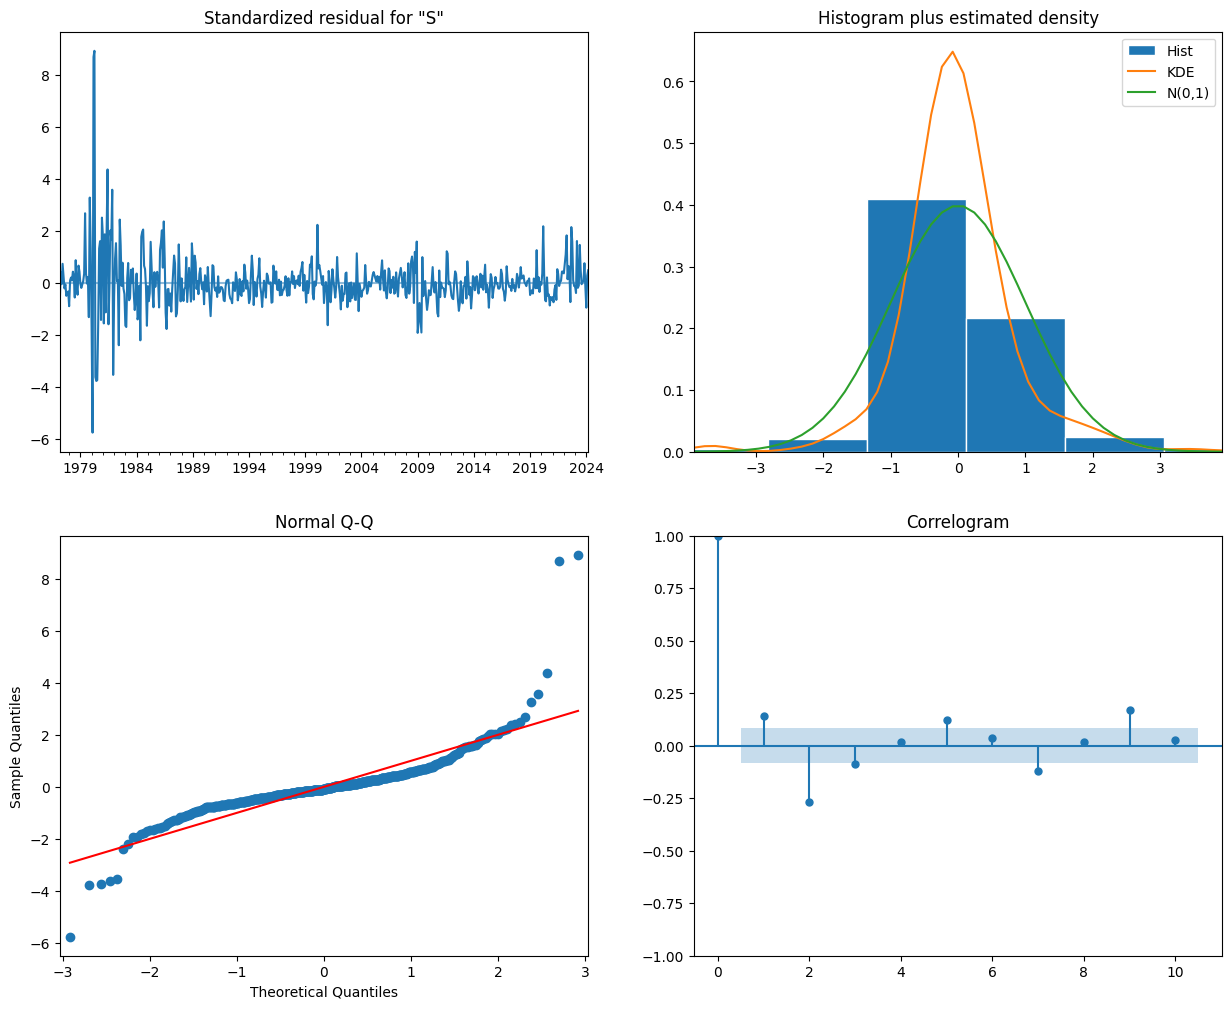

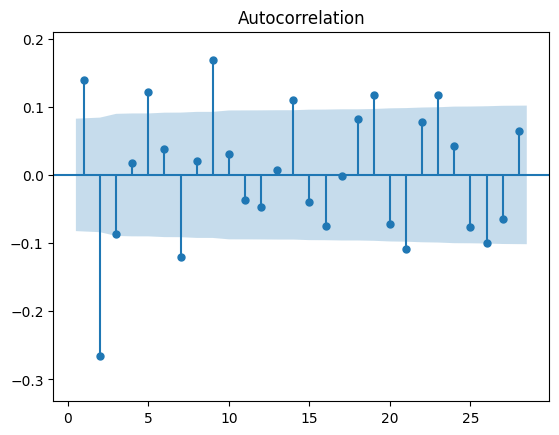

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}          &      SPREAD      & \textbf{  No. Observations:  } &    565      \\
\textbf{Model:}                  &  ARIMA(1, 0, 0)  & \textbf{  Log Likelihood     } &   24.391    \\
\textbf{Date:}                   & Sun, 05 May 2024 & \textbf{  AIC                } &  -42.782    \\
\textbf{Time:}                   &     02:09:03     & \textbf{  BIC                } &  -29.772    \\
\textbf{Sample:}                 &    03-01-1977    & \textbf{  HQIC               } &  -37.704    \\
\textbf{}                        &   - 03-01-2024   & \textbf{                     } &             \\
\textbf{Covariance Type:}        &       opg        & \textbf{                     } &             \\
\bottomrule
\end{tabular}
\begin{tabular}{lcccccc}
                & \textbf{coef} & \textbf{std err} & \textbf{z} & \textbf{P$> |$z$|$} & \textbf{[0.025} & \textbf{0.975]}  \\
\midrule
\textbf{const}  &       1.4323  &        0.240     &  

In [20]:
#AR(1) full spread time series
model = ARIMA_fit(data_month.SPREAD)
print(model.model_fit.summary().as_latex())

In [21]:
print(model_110.model_fit.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}          &      SPREAD      & \textbf{  No. Observations:  } &    447      \\
\textbf{Model:}                  &  ARIMA(1, 1, 0)  & \textbf{  Log Likelihood     } &  277.598    \\
\textbf{Date:}                   & Sun, 05 May 2024 & \textbf{  AIC                } &  -551.197   \\
\textbf{Time:}                   &     02:09:03     & \textbf{  BIC                } &  -542.996   \\
\textbf{Sample:}                 &    01-01-1987    & \textbf{  HQIC               } &  -547.963   \\
\textbf{}                        &   - 03-01-2024   & \textbf{                     } &             \\
\textbf{Covariance Type:}        &       opg        & \textbf{                     } &             \\
\bottomrule
\end{tabular}
\begin{tabular}{lcccccc}
                & \textbf{coef} & \textbf{std err} & \textbf{z} & \textbf{P$> |$z$|$} & \textbf{[0.025} & \textbf{0.975]}  \\
\midrule
\textbf{ar.L1}  &       0.1702  &        0.036     &  